# Simple 4-Layer Neural Network to classify Palmtrees
---

In [7]:
import numpy as np
#import h5py
import matplotlib.pyplot as plt
#import scipy
#from PIL import Image
#from scipy import ndimage
import pandas as pd
#import glob
#import os
import csv
#from PIL import Image
import cv2
#import copy
#from scipy import ndimage
from sklearn.model_selection import train_test_split

## Define our Activation functions and their derivatives

In [2]:
def sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache

def relu(Z):
    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)
    
    cache = Z 
    return A, cache

def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

def sigmoid_backward(dA, cache):
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ

In [3]:
def initialize_parameters_deep(layer_dims):
    parameters = {}
    L = len(layer_dims) # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
         
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l - 1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))
        
    return parameters
#################################################
def linear_forward(A, W, b):
 
    Z=np.dot(W,A)+b
    cache = (A, W, b)
    
    return Z, cache
def linear_activation_forward(A_prev, W, b, activation):

    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
       
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
       
    cache = (linear_cache, activation_cache)

    return A, cache

def L_model_forward(X, parameters):


    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W'+str(l)], parameters['b'+str(l)], activation="relu")
        caches.append(cache)
    AL, cache = linear_activation_forward(A, parameters['W'+str(L)], parameters['b'+str(L)], activation="sigmoid")
    caches.append(cache)
      
    return AL, caches
#################################################
def compute_cost(AL, Y):
    m = Y.shape[1]
    cost=- np.sum(np.multiply(np.log(AL),Y) + np.multiply(np.log(1-AL),1-Y))/m
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    
    return cost
#################################################
def linear_backward(dZ, cache):

    A_prev, W, b = cache
    m = A_prev.shape[1]
    
    dW=np.dot(dZ,A_prev.T)/m
    db=np.sum(dZ, axis=1, keepdims=True)/m
    dA_prev=np.dot(W.T, dZ)
   
    return dA_prev, dW, db


def linear_activation_backward(dA, cache, activation):
    
    linear_cache, activation_cache = cache
    
    if activation == "relu":    
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db =linear_backward(dZ, linear_cache)
        
    elif activation == "sigmoid":

        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db =linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL

    dAL=- (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))

    current_cache = caches[L-1]
    dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dAL, current_cache, "sigmoid")
    grads["dA" + str(L-1)] = dA_prev_temp
    grads["dW" + str(L)] =  dW_temp
    grads["db" + str(L)] =db_temp

    for l in reversed(range(L-1)):

        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l+1)], current_cache, "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads
#################################################
def update_parameters(params, grads, learning_rate):

    parameters = params.copy()
    L = len(parameters) // 2 # number of layers in the neural network

    for l in range(L):

        parameters["W" + str(l+1)] =  params["W" + str(l+1)] -learning_rate*grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] =  params["b" + str(l+1)] -learning_rate*grads["db" + str(l+1)]

    return parameters

In [4]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):

    np.random.seed(1)
    costs = []                         # keep track of cost

    parameters = initialize_parameters_deep(layers_dims)

    for i in range(0, num_iterations):
 
        AL, caches = L_model_forward(X, parameters)

        cost = compute_cost(AL, Y)

        grads = L_model_backward(AL, Y, caches)

        parameters = update_parameters(parameters, grads, learning_rate)

        # Print the cost every 100 iterations
        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)
    
    return parameters, costs

## Import Data

In [5]:
palm=pd.read_csv('palmtree_annotations.csv')
palm["Label"].iloc[576]='palmtree'
palm["Label"]=palm["Label"].str.replace('nope','0').str.replace('palmtree','1')
palm = palm.iloc[:-1 , :]

In [9]:
Y=palm["Label"].to_list()
X= np.array([cv2.imread(file).tolist() for file in palm["Image_name"].to_list()])
X_flatten =X.reshape(X.shape[0],-1).T
Y_flatten=np.reshape(np.array(Y),(1,len(Y)))
palm_shuffled=palm.sample(frac=1).reset_index(drop=True)

In [10]:
# split the data into train and test set
train, test = train_test_split(palm_shuffled, test_size=0.2, random_state=42, shuffle=True)

In [11]:
#Bilder laden..
Ytrain=train["Label"].to_list()
train_y=np.reshape(np.array(Ytrain,dtype=float),(1,len(Ytrain)))
Xtrain= np.array([cv2.imread(file).tolist() for file in train["Image_name"].to_list()])
train_x =Xtrain.reshape(Xtrain.shape[0],-1).T
Ytest=test["Label"].to_list()
test_y=np.reshape(np.array(Ytest,dtype=float),(1,len(Ytest)))
Xtest= np.array([cv2.imread(file).tolist() for file in test["Image_name"].to_list()])
test_x =Xtest.reshape(Xtest.shape[0],-1).T

# Run a Model

In [12]:
### CONSTANTS ###
layers_dims = [X_flatten.shape[0], 20, 7, 5, 1] #  4-layer model

In [13]:
parameters, costs = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)

Cost after iteration 0: 0.6936982779381906
Cost after iteration 100: 0.3435940943571394
Cost after iteration 200: 0.329590003307636
Cost after iteration 300: 0.2888920729263161
Cost after iteration 400: 0.2525197782813586
Cost after iteration 500: 0.18176324419753634
Cost after iteration 600: 0.14456518207638824
Cost after iteration 700: 0.10499423407106935
Cost after iteration 800: 0.1198732423037415
Cost after iteration 900: 0.10599631263449802
Cost after iteration 1000: 0.0860665735869592
Cost after iteration 1100: 0.08121990105476828
Cost after iteration 1200: 0.07859171007850672
Cost after iteration 1300: 0.07668361922158297
Cost after iteration 1400: 0.07421233861761974
Cost after iteration 1500: 0.07229243469654965
Cost after iteration 1600: 0.0704330130037399
Cost after iteration 1700: 0.06867983843181581
Cost after iteration 1800: 0.06705066498748777
Cost after iteration 1900: 0.06540526207103213
Cost after iteration 2000: 0.06387775333465509
Cost after iteration 2100: 0.06241

# Results

In [14]:
def predict(X, y, parameters):

    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)

    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    #print results
    #print ("predictions: " + str(p))
    #print ("true labels: " + str(y))
    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p

In [15]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.9961685823754787


In [16]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.8931297709923665


In [17]:
def print_mislabeled_images( X, y, p):
    
    a = p + y
    mislabeled_indices = np.asarray(np.where(a == 1))
    plt.rcParams['figure.figsize'] = (40.0, 40.0) # set default size of plots
    num_images = len(mislabeled_indices[0])
    for i in range(num_images):
        index = mislabeled_indices[1][i]
        
        plt.subplot(2, num_images, i + 1)
        plt.imshow(X[:,index].reshape(100,100,3), interpolation='nearest')
        plt.axis('off')
        #plt.title("Prediction: " + classes[int(p[0,index])].decode("utf-8") + " \n Class: " + classes[y[0,index]].decode("utf-8"))

In [18]:
def print_rightlabeled_images( X, y, p):
    
    a = p + y
    rightlabeled_indices = np.asarray(np.where(a != 1))
    plt.rcParams['figure.figsize'] = (40.0, 40.0) # set default size of plots
    num_images = len(rightlabeled_indices[0])
    for i in range(num_images):
        index = rightlabeled_indices[1][i]
        
        #plt.subplot(2, num_images, i + 1)
        plt.imshow(X[:,index].reshape(100,100,3), interpolation='nearest')
        plt.axis('off')
        #plt.title("Prediction: " + classes[int(p[0,index])].decode("utf-8") + " \n Class: " + classes[y[0,index]].decode("utf-8"))

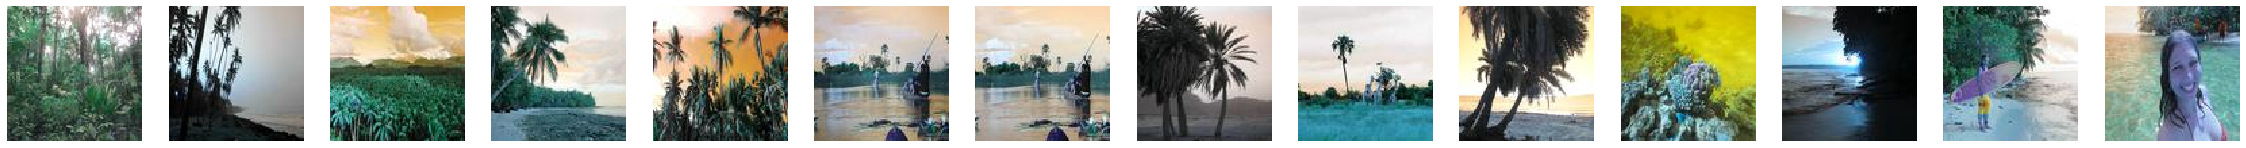

In [19]:
print_mislabeled_images(test_x, test_y, pred_test)